In [71]:
#%tensorflow_version 2.x
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import json

In [72]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, Conv2DTranspose ,MaxPooling2D, LSTM, LSTMCell, SimpleRNNCell
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adadelta, RMSprop, Adam, SGD
from tensorflow.python.keras import backend as K
from tensorflow.keras.regularizers import l2
from skimage.io import imread
from skimage import color
from PIL import Image


In [69]:
def normalizeData(data):
    maxValue = np.max(data[0])
    minValue = np.min(data[0])
    for img in data[1:]:
        newMax = np.max(img) 
        newMin = np.min(img)
        if newMax > maxValue:
            maxValue = newMax
        if newMin < minValue:
            minValue = newMin    
    
    normalizedData = (data - minValue) / (maxValue - minValue)
    return normalizedData

def prepareData( dirPath, mode ):
    images = []
    fileNames = os.listdir(dirPath)
    for filename in fileNames:
        path = dirPath + '/' + filename
        if mode == 'gray':
            img = imread(path, as_gray=True)
        else:
            img = imread(path)
        images.append(img)
    
    #print("max: ",np.max(np.array(images)))
    
    return normalizeData(np.array(images))

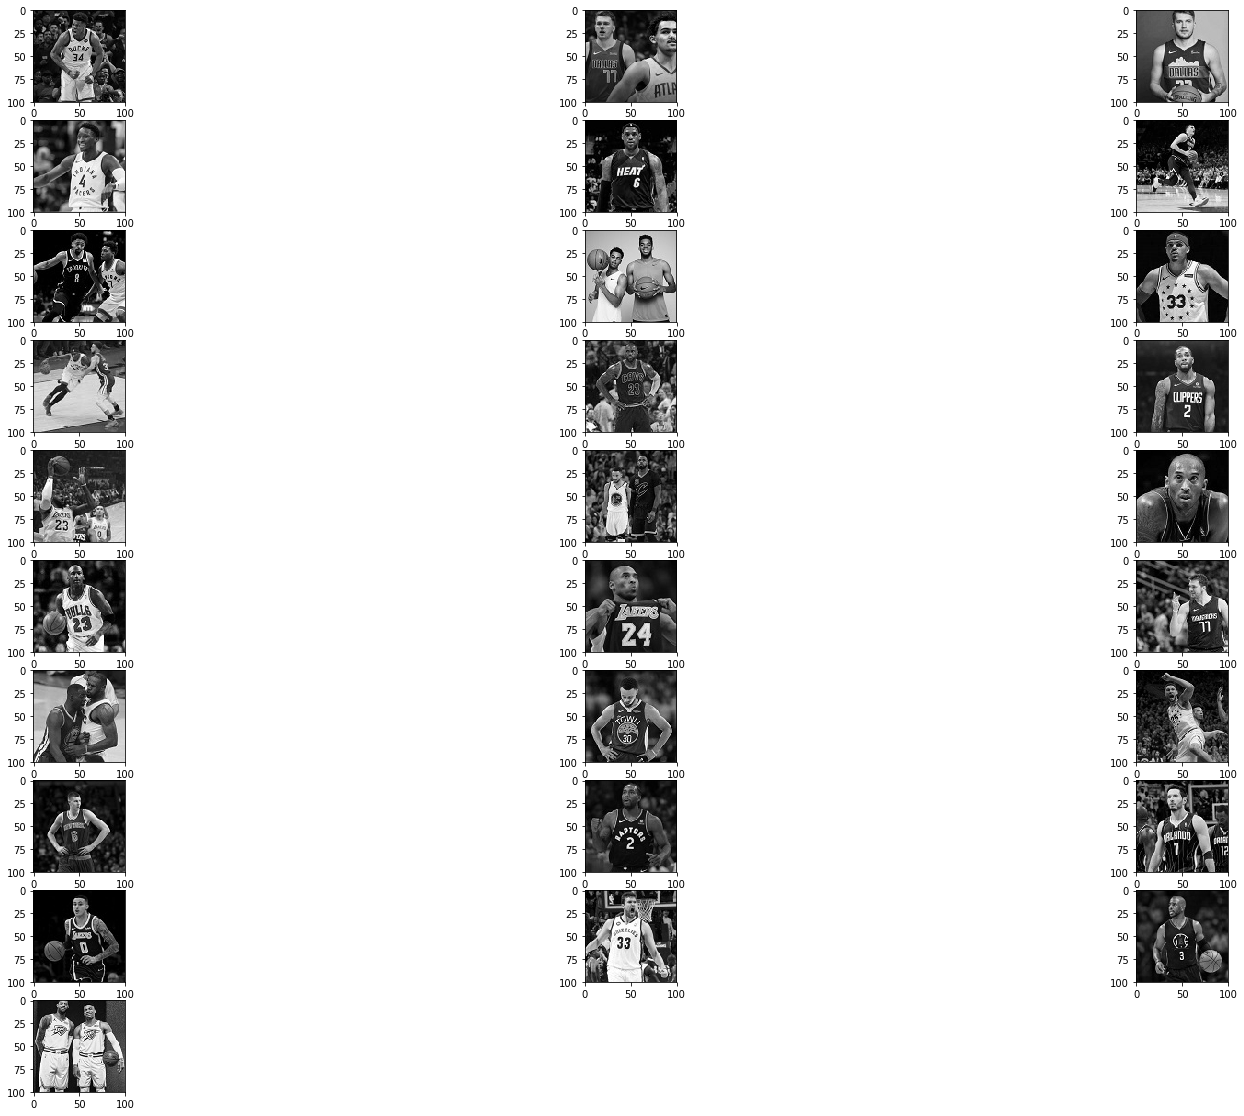

In [70]:
x_train = prepareData('rgbimages', 'gray')
x_train = x_train[:, :, :, np.newaxis].astype('float32')
y_train = prepareData('rgbimages', '')  

n= len(x_train)
f = plt.figure(figsize = (n,n))
for i in range(len(x_train)):
    f.add_subplot(max(n/2,1),3 , i + 1)
    plt.imshow(x_train[i][:,:,0], vmin=0, vmax=1 ,cmap='gray')
    
plt.show(block=True)

# Model autoenkodera

In [73]:
class Encoder(Model):

    def createConv2DLayer(self, numFilters, stride, weight_decay):
        return Conv2D(numFilters, 
                      input_shape = ( None, None, 1),
                      kernel_size = self.kernel_size,
                      strides = stride,
                      activation = 'relu',
                      kernel_regularizer=l2(weight_decay))
    
    def __init__(self,
                 kernelSize, 
                 strides,
                 dropoutRate,
                 startNumFilters,
                 weightDecay,
                 isBatchNormalization
                ):
        super(Encoder, self).__init__(name='encoder')
        self.kernel_size = kernelSize
        self.stride = strides
        self.dropout_rate = dropoutRate     
        self.weight_decay = weightDecay
        self.is_batch_normalization = isBatchNormalization 
        #layers
        self.layer_1 = self.createConv2DLayer(startNumFilters, strides, weightDecay)
        self.layer_11 = BatchNormalization()
        self.layer_2 = Dropout(dropoutRate)
        self.layer_3 = self.createConv2DLayer(2*startNumFilters, strides, weightDecay)
        self.layer_4 = Dropout(dropoutRate)
        self.layer_5 = self.createConv2DLayer(4*startNumFilters, strides, weightDecay)
        self.layer_55 = BatchNormalization()
        self.layer_8 = Dropout(dropoutRate)
        
    def call(self, inputs):
        # call layers
        x = self.layer_1(inputs)
        if (self.is_batch_normalization == True):
            x = self.layer_11(x)
        x = self.layer_2(x)
        x = K.relu(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = K.relu(x)
        x = self.layer_5(x)
        if (self.is_batch_normalization == True):
            x = self.layer_55(x)
        x = self.layer_8(x)
        x = K.relu(x)
        return x


In [74]:
class Decoder(Model):

    def createConv2DTransposeLayer(self, 
                                   numFilters, 
                                   activateFunction, 
                                   stride,
                                   weight_decay):
        return Conv2DTranspose(numFilters, 
                      kernel_size = self.kernel_size,
                      strides = stride,
                      activation = activateFunction,
                      kernel_regularizer=l2(weight_decay)
                     )
    
    
    def __init__(self,  
                 kernelSize, 
                 strides,
                 dropoutRate,
                 startNumFilters,
                 weightDecay,
                 isBatchNormalization
                ):
        super(Decoder, self).__init__(name='decoder')
        self.kernel_size = kernelSize
        self.stride = strides
        self.dropout_rate = dropoutRate     
        self.weight_decay = weightDecay
        self.is_batch_normalization = isBatchNormalization
        #layers
        self.layer_1 = self.createConv2DTransposeLayer(startNumFilters, 'relu', strides, weightDecay)
        self.layer_11 = BatchNormalization()
        self.layer_2 = Dropout(self.dropout_rate)
        self.layer_3 = self.createConv2DTransposeLayer(int(startNumFilters/2), 'relu' , strides, weightDecay)
        self.layer_4 = Dropout(self.dropout_rate)
        self.layer_9 = self.createConv2DTransposeLayer(3, 'sigmoid' , strides, weightDecay)
        
        
    def call(self, inputs):
        # call layers
        x = self.layer_1(inputs)
        if (self.is_batch_normalization == True):
            x = self.layer_11(x)
        x = self.layer_2(x)
        x = K.relu(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = K.relu(x)
        x = self.layer_9(x)
        return x

In [75]:
class AutoEncoder(Model):
    def __init__(self, 
                 kernelSize = (2,2),
                 stride = (1,1),
                 dropoutRate = 0.5,
                 startNumFilters = 32,
                 weightDecay = 0.0,
                 isBatchNormalization = False
                ):
          super(AutoEncoder, self).__init__(name='autoencoder')
          self.kernel_size = kernelSize
          self.strides = stride
          self.dropout_rate = dropoutRate
          self.start_num_filters = startNumFilters
          self.weight_decay = weightDecay
          self.is_batch_normalization = isBatchNormalization
          self.encoder = Encoder(kernelSize, 
                                 stride,
                                 dropoutRate,
                                 startNumFilters,
                                 weightDecay,
                                 isBatchNormalization)
          self.decoder = Decoder(kernelSize, 
                                 stride,
                                 dropoutRate,
                                 3 * startNumFilters,
                                 weightDecay,
                                 isBatchNormalization)

    def call(self, inputs):
          # Define your forward pass here,
          # using layers you previously defined (in `__init__`).
          x = self.encoder(inputs)
          x = self.decoder(x)
          return x
        
    def get_config(self):
        return {'kernel_size': self.kernel_size,'strides' : self.strides,'dropout_rate' : self.dropout_rate,'start_num_filters' : self.start_num_filters,'pool_size' : self.pool_size, 'weight_decay': self.weight_decay}
        
    def from_config(cls, config):
          return cls(**config)
    


# Vectors of Parameters
single_vector = [ isBatchNormalization, momentum (beta_1), batch_size , dropout_rate , weight_decay]

In [76]:
parameterVectors = [
    [False, 0.9, 14, 0.5, 0.0],
    [False, 0.9, 14, 0.3, 0.0005],
    [False, 0.7, 14, 0, 0],
    [True, 0.9, 14, 0.5, 0],
    [True, 0.7, 14, 0, 0.0005],
    [False, 0.9, 28, 0.5, 0],
    [False, 0.9, 28, 0.3, 0.0005],
    [False, 0.7, 28, 0, 0],
    [True, 0.9, 28, 0.5, 0],
    [True, 0.7, 28, 0, 0.0005]
]

parameters = [
    'isBatchNormalization',
    'momentum(beta_1)',
    'batch_size',
    'dropout_rate',
    'weight_decay'
]

def zipParameters(vector):
    return dict(zip(parameters, vector))

def convertToFloat(hist):
    losses= []
    accs = []
    for ob in hist.history['loss']:
        losses.append(float(ob))
    for ob in hist.history['acc']:
        accs.append(float(ob))
    return {
        'loss' : losses,
        'acc' : accs
    }

def finalResults(hist):    
    return {
        'final_loss' : float(hist.history['loss'][-1]),
        'final_acc' : float(hist.history['acc'][-1])
    }
    
    

# Adam optimizer training

In [ ]:
for index in range(len(parameterVectors)):
    vector = parameterVectors[index]
    autoencoder = AutoEncoder(kernelSize = (2,2),
                          stride = 1,
                          dropoutRate = vector[3],
                          startNumFilters = 32,
                          weightDecay = vector[4],
                          isBatchNormalization = vector[0]
                         )
    autoencoder.compile(loss=mean_squared_error,
              optimizer=Adam(learning_rate= 0.001, beta_1 = vector[1]),
              metrics=['acc'])
    hist = autoencoder.fit(x_train, y_train, epochs=400,batch_size=vector[2])
    #save weights
    folder_name = 'Adam'+str(index)
    path_to_variables = folder_name+'/path_to_weights'
    path_to_results = folder_name+'/results.json'
    os.mkdir(folder_name)
    autoencoder.save_weights(path_to_variables, save_format = 'tf')
    convertToFloat(hist)
    with open(path_to_results, 'w') as f:
        jsonData = {
            'history': convertToFloat(hist),
            'final' : finalResults(hist),
            'parameters': zipParameters(vector)
        }
        json.dump(jsonData, f)


# SGD optimizer training

In [121]:
for index in range(len(parameterVectors)):
    vector = parameterVectors[index]
    autoencoder = AutoEncoder(kernelSize = (2,2),
                          stride = 1,
                          dropoutRate = vector[3],
                          startNumFilters = 32,
                          weightDecay = vector[4],
                          isBatchNormalization = vector[0]
                         )
    autoencoder.compile(loss=mean_squared_error,
              optimizer=SGD(learning_rate= 0.01, momentum = vector[1]),
              metrics=['acc'])
    hist = autoencoder.fit(x_train, y_train, epochs=400,batch_size=vector[2])
    #save weights
    folder_name = 'SGD'+str(index)
    path_to_variables = folder_name+'/path_to_weights'
    path_to_results = folder_name+'/results.json'
    os.mkdir(folder_name)
    autoencoder.save_weights(path_to_variables, save_format = 'tf')
    convertToFloat(hist)
    with open(path_to_results, 'w') as f:
        jsonData = {
            'history': convertToFloat(hist),
            'final' : finalResults(hist),
            'parameters': zipParameters(vector)
        }
        json.dump(jsonData, f)

Train on 28 samples
Epoch 1/400
28/28 [==============================] - 7s 254ms/sample - loss: 0.1166 - acc: 0.3805
Epoch 2/400
28/28 [==============================] - 5s 192ms/sample - loss: 0.1165 - acc: 0.3869
Epoch 3/400
28/28 [==============================] - 5s 188ms/sample - loss: 0.1161 - acc: 0.3955
Epoch 4/400
28/28 [==============================] - 6s 216ms/sample - loss: 0.1156 - acc: 0.4049
Epoch 5/400
28/28 [==============================] - 6s 209ms/sample - loss: 0.1151 - acc: 0.4153
Epoch 6/400
28/28 [==============================] - 6s 204ms/sample - loss: 0.1145 - acc: 0.4225
Epoch 7/400
28/28 [==============================] - 5s 193ms/sample - loss: 0.1138 - acc: 0.4342
Epoch 8/400
28/28 [==============================] - 6s 226ms/sample - loss: 0.1131 - acc: 0.4433
Epoch 9/400
28/28 [==============================] - 6s 205ms/sample - loss: 0.1123 - acc: 0.4528
Epoch 10/400
28/28 [==============================] - 6s 227ms/sample - loss: 0.1115 - acc: 0.4619

28/28 [==============================] - 5s 182ms/sample - loss: 0.0257 - acc: 0.5092
Epoch 166/400
28/28 [==============================] - 5s 181ms/sample - loss: 0.0257 - acc: 0.5105
Epoch 167/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0256 - acc: 0.5109
Epoch 168/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0254 - acc: 0.5106
Epoch 169/400
28/28 [==============================] - 5s 181ms/sample - loss: 0.0255 - acc: 0.5106
Epoch 170/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0255 - acc: 0.5121
Epoch 171/400
28/28 [==============================] - 5s 181ms/sample - loss: 0.0255 - acc: 0.5141
Epoch 172/400
28/28 [==============================] - 5s 183ms/sample - loss: 0.0253 - acc: 0.5150
Epoch 173/400
28/28 [==============================] - 5s 183ms/sample - loss: 0.0253 - acc: 0.5148
Epoch 174/400
28/28 [==============================] - 5s 181ms/sample - loss: 0.0254 - acc: 0.5158
Epoch 175/400


28/28 [==============================] - 5s 186ms/sample - loss: 0.0238 - acc: 0.5490
Epoch 248/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0238 - acc: 0.5475
Epoch 249/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0238 - acc: 0.5491
Epoch 250/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0237 - acc: 0.5507
Epoch 251/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0237 - acc: 0.5501
Epoch 252/400
28/28 [==============================] - 5s 181ms/sample - loss: 0.0237 - acc: 0.5503
Epoch 253/400
28/28 [==============================] - 5s 186ms/sample - loss: 0.0238 - acc: 0.5505
Epoch 254/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0236 - acc: 0.5511
Epoch 255/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0236 - acc: 0.5508
Epoch 256/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0236 - acc: 0.5499
Epoch 257/400


28/28 [==============================] - 5s 178ms/sample - loss: 0.0227 - acc: 0.5670
Epoch 330/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0228 - acc: 0.5678
Epoch 331/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0227 - acc: 0.5669
Epoch 332/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0228 - acc: 0.5675
Epoch 333/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0227 - acc: 0.5680
Epoch 334/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0227 - acc: 0.5686
Epoch 335/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0227 - acc: 0.5696
Epoch 336/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0228 - acc: 0.5692
Epoch 337/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0227 - acc: 0.5689
Epoch 338/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0227 - acc: 0.5692
Epoch 339/400


28/28 [==============================] - 5s 179ms/sample - loss: 0.2640 - acc: 0.5671
Epoch 12/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.2632 - acc: 0.5731
Epoch 13/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2621 - acc: 0.5776
Epoch 14/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2612 - acc: 0.5817
Epoch 15/400
28/28 [==============================] - 5s 183ms/sample - loss: 0.2603 - acc: 0.5857
Epoch 16/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.2593 - acc: 0.5900
Epoch 17/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2584 - acc: 0.5926
Epoch 18/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2574 - acc: 0.5960
Epoch 19/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2565 - acc: 0.5985
Epoch 20/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.2555 - acc: 0.6000
Epoch 21/400
28/28 [===

28/28 [==============================] - 5s 185ms/sample - loss: 0.1667 - acc: 0.5860
Epoch 176/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1667 - acc: 0.5849
Epoch 177/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1666 - acc: 0.5859
Epoch 178/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1666 - acc: 0.5865
Epoch 179/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1664 - acc: 0.5864
Epoch 180/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.1664 - acc: 0.5857
Epoch 181/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1663 - acc: 0.5866
Epoch 182/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.1662 - acc: 0.5881
Epoch 183/400
28/28 [==============================] - 5s 181ms/sample - loss: 0.1661 - acc: 0.5877
Epoch 184/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.1661 - acc: 0.5864
Epoch 185/400


28/28 [==============================] - 6s 207ms/sample - loss: 0.1611 - acc: 0.5997
Epoch 258/400
28/28 [==============================] - 6s 213ms/sample - loss: 0.1610 - acc: 0.6000
Epoch 259/400
28/28 [==============================] - 6s 204ms/sample - loss: 0.1609 - acc: 0.6015
Epoch 260/400
28/28 [==============================] - 7s 250ms/sample - loss: 0.1609 - acc: 0.6004
Epoch 261/400
28/28 [==============================] - 7s 245ms/sample - loss: 0.1609 - acc: 0.6011
Epoch 262/400
28/28 [==============================] - 7s 251ms/sample - loss: 0.1608 - acc: 0.6023
Epoch 263/400
28/28 [==============================] - 6s 229ms/sample - loss: 0.1608 - acc: 0.6024
Epoch 264/400
28/28 [==============================] - 6s 221ms/sample - loss: 0.1606 - acc: 0.6014
Epoch 265/400
28/28 [==============================] - 6s 208ms/sample - loss: 0.1606 - acc: 0.6019
Epoch 266/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.1606 - acc: 0.6035
Epoch 267/400


28/28 [==============================] - 6s 199ms/sample - loss: 0.1560 - acc: 0.6117
Epoch 340/400
28/28 [==============================] - 6s 199ms/sample - loss: 0.1560 - acc: 0.6099
Epoch 341/400
28/28 [==============================] - 6s 202ms/sample - loss: 0.1559 - acc: 0.6120
Epoch 342/400
28/28 [==============================] - 6s 198ms/sample - loss: 0.1559 - acc: 0.6115
Epoch 343/400
28/28 [==============================] - 6s 198ms/sample - loss: 0.1558 - acc: 0.6104
Epoch 344/400
28/28 [==============================] - 6s 198ms/sample - loss: 0.1558 - acc: 0.6112
Epoch 345/400
28/28 [==============================] - 5s 196ms/sample - loss: 0.1557 - acc: 0.6101
Epoch 346/400
28/28 [==============================] - 6s 198ms/sample - loss: 0.1556 - acc: 0.6115
Epoch 347/400
28/28 [==============================] - 5s 195ms/sample - loss: 0.1556 - acc: 0.6121
Epoch 348/400
28/28 [==============================] - 6s 197ms/sample - loss: 0.1555 - acc: 0.6123
Epoch 349/400


28/28 [==============================] - 4s 140ms/sample - loss: 0.0724 - acc: 0.6433
Epoch 104/400
28/28 [==============================] - 4s 139ms/sample - loss: 0.0719 - acc: 0.6433
Epoch 105/400
28/28 [==============================] - 4s 139ms/sample - loss: 0.0715 - acc: 0.6433
Epoch 106/400
28/28 [==============================] - 4s 137ms/sample - loss: 0.0710 - acc: 0.6433
Epoch 107/400
28/28 [==============================] - 4s 140ms/sample - loss: 0.0705 - acc: 0.6433
Epoch 108/400
28/28 [==============================] - 4s 138ms/sample - loss: 0.0701 - acc: 0.6433
Epoch 109/400
28/28 [==============================] - 4s 137ms/sample - loss: 0.0696 - acc: 0.6433
Epoch 110/400
28/28 [==============================] - 4s 138ms/sample - loss: 0.0691 - acc: 0.6433
Epoch 111/400
28/28 [==============================] - 4s 137ms/sample - loss: 0.0686 - acc: 0.6433
Epoch 112/400
28/28 [==============================] - 4s 138ms/sample - loss: 0.0682 - acc: 0.6433
Epoch 113/400


28/28 [==============================] - 4s 141ms/sample - loss: 0.0294 - acc: 0.6424
Epoch 186/400
28/28 [==============================] - 4s 140ms/sample - loss: 0.0290 - acc: 0.6424
Epoch 187/400
28/28 [==============================] - 4s 144ms/sample - loss: 0.0286 - acc: 0.6424
Epoch 188/400
28/28 [==============================] - 4s 139ms/sample - loss: 0.0283 - acc: 0.6424
Epoch 189/400
28/28 [==============================] - 4s 139ms/sample - loss: 0.0280 - acc: 0.6424
Epoch 190/400
28/28 [==============================] - 4s 139ms/sample - loss: 0.0276 - acc: 0.6423
Epoch 191/400
28/28 [==============================] - 4s 140ms/sample - loss: 0.0273 - acc: 0.6424
Epoch 192/400
28/28 [==============================] - 4s 139ms/sample - loss: 0.0270 - acc: 0.6424
Epoch 193/400
28/28 [==============================] - 4s 140ms/sample - loss: 0.0267 - acc: 0.6423
Epoch 194/400
28/28 [==============================] - 4s 140ms/sample - loss: 0.0264 - acc: 0.6423
Epoch 195/400


28/28 [==============================] - 4s 139ms/sample - loss: 0.0181 - acc: 0.6423
Epoch 268/400
28/28 [==============================] - 4s 140ms/sample - loss: 0.0181 - acc: 0.6423
Epoch 269/400
28/28 [==============================] - 4s 141ms/sample - loss: 0.0181 - acc: 0.6423
Epoch 270/400
28/28 [==============================] - 4s 141ms/sample - loss: 0.0181 - acc: 0.6423
Epoch 271/400
28/28 [==============================] - 4s 144ms/sample - loss: 0.0180 - acc: 0.6423
Epoch 272/400
28/28 [==============================] - 4s 143ms/sample - loss: 0.0180 - acc: 0.6423
Epoch 273/400
28/28 [==============================] - 4s 142ms/sample - loss: 0.0180 - acc: 0.6423
Epoch 274/400
28/28 [==============================] - 4s 143ms/sample - loss: 0.0180 - acc: 0.6423
Epoch 275/400
28/28 [==============================] - 4s 142ms/sample - loss: 0.0179 - acc: 0.6423
Epoch 276/400
28/28 [==============================] - 4s 144ms/sample - loss: 0.0179 - acc: 0.6423
Epoch 277/400


28/28 [==============================] - 4s 140ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 350/400
28/28 [==============================] - 4s 141ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 351/400
28/28 [==============================] - 4s 142ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 352/400
28/28 [==============================] - 4s 140ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 353/400
28/28 [==============================] - 4s 142ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 354/400
28/28 [==============================] - 4s 150ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 355/400
28/28 [==============================] - 4s 142ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 356/400
28/28 [==============================] - 4s 141ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 357/400
28/28 [==============================] - 4s 139ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 358/400
28/28 [==============================] - 4s 138ms/sample - loss: 0.0170 - acc: 0.6418
Epoch 359/400


28/28 [==============================] - 10s 344ms/sample - loss: 0.0477 - acc: 0.4493
Epoch 114/400
28/28 [==============================] - 9s 322ms/sample - loss: 0.0472 - acc: 0.4499
Epoch 115/400
28/28 [==============================] - 10s 351ms/sample - loss: 0.0468 - acc: 0.4517
Epoch 116/400
28/28 [==============================] - 11s 387ms/sample - loss: 0.0468 - acc: 0.4510
Epoch 117/400
28/28 [==============================] - 10s 368ms/sample - loss: 0.0464 - acc: 0.4511
Epoch 118/400
28/28 [==============================] - 10s 364ms/sample - loss: 0.0460 - acc: 0.4533
Epoch 119/400
28/28 [==============================] - 11s 377ms/sample - loss: 0.0467 - acc: 0.4527
Epoch 120/400
28/28 [==============================] - 10s 339ms/sample - loss: 0.0461 - acc: 0.4539
Epoch 121/400
28/28 [==============================] - 10s 355ms/sample - loss: 0.0468 - acc: 0.4550
Epoch 122/400
28/28 [==============================] - 9s 337ms/sample - loss: 0.0465 - acc: 0.4570
Epoch 

28/28 [==============================] - 8s 288ms/sample - loss: 0.0326 - acc: 0.5377
Epoch 276/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0330 - acc: 0.5384
Epoch 277/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0328 - acc: 0.5398
Epoch 278/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0326 - acc: 0.5389
Epoch 279/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0327 - acc: 0.5405
Epoch 280/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0324 - acc: 0.5405
Epoch 281/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0330 - acc: 0.5399
Epoch 282/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0329 - acc: 0.5411
Epoch 283/400
28/28 [==============================] - 8s 295ms/sample - loss: 0.0330 - acc: 0.5401
Epoch 284/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0324 - acc: 0.5411
Epoch 285/400


28/28 [==============================] - 8s 286ms/sample - loss: 0.0297 - acc: 0.5593
Epoch 358/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0298 - acc: 0.5609
Epoch 359/400
28/28 [==============================] - 8s 286ms/sample - loss: 0.0297 - acc: 0.5614
Epoch 360/400
28/28 [==============================] - 8s 285ms/sample - loss: 0.0296 - acc: 0.5613
Epoch 361/400
28/28 [==============================] - 8s 286ms/sample - loss: 0.0296 - acc: 0.5613
Epoch 362/400
28/28 [==============================] - 8s 286ms/sample - loss: 0.0296 - acc: 0.5613
Epoch 363/400
28/28 [==============================] - 8s 286ms/sample - loss: 0.0308 - acc: 0.5606
Epoch 364/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0298 - acc: 0.5622
Epoch 365/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0303 - acc: 0.5609
Epoch 366/400
28/28 [==============================] - 8s 286ms/sample - loss: 0.0295 - acc: 0.5626
Epoch 367/400


28/28 [==============================] - 7s 238ms/sample - loss: 0.1675 - acc: 0.5164
Epoch 122/400
28/28 [==============================] - 6s 232ms/sample - loss: 0.1682 - acc: 0.5118
Epoch 123/400
28/28 [==============================] - 6s 232ms/sample - loss: 0.1680 - acc: 0.5146
Epoch 124/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1674 - acc: 0.5137
Epoch 125/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1675 - acc: 0.5147
Epoch 126/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1672 - acc: 0.5193
Epoch 127/400
28/28 [==============================] - 6s 232ms/sample - loss: 0.1693 - acc: 0.5144
Epoch 128/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1675 - acc: 0.5199
Epoch 129/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1682 - acc: 0.5199
Epoch 130/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1670 - acc: 0.5213
Epoch 131/400


28/28 [==============================] - 7s 234ms/sample - loss: 0.1637 - acc: 0.5463
Epoch 204/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1637 - acc: 0.5472
Epoch 205/400
28/28 [==============================] - 6s 232ms/sample - loss: 0.1643 - acc: 0.5491
Epoch 206/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1633 - acc: 0.5485
Epoch 207/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1633 - acc: 0.5481
Epoch 208/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1636 - acc: 0.5481
Epoch 209/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1634 - acc: 0.5506
Epoch 210/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1633 - acc: 0.5478
Epoch 211/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1635 - acc: 0.5472
Epoch 212/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1633 - acc: 0.5519
Epoch 213/400


28/28 [==============================] - 7s 233ms/sample - loss: 0.1605 - acc: 0.5603
Epoch 286/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1604 - acc: 0.5624
Epoch 287/400
28/28 [==============================] - 6s 232ms/sample - loss: 0.1605 - acc: 0.5610
Epoch 288/400
28/28 [==============================] - 6s 232ms/sample - loss: 0.1609 - acc: 0.5639
Epoch 289/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1607 - acc: 0.5641
Epoch 290/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1603 - acc: 0.5617
Epoch 291/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1621 - acc: 0.5578
Epoch 292/400
28/28 [==============================] - 6s 232ms/sample - loss: 0.1606 - acc: 0.5594
Epoch 293/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1602 - acc: 0.5597
Epoch 294/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1602 - acc: 0.5614
Epoch 295/400


28/28 [==============================] - 7s 233ms/sample - loss: 0.1584 - acc: 0.5733
Epoch 368/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1579 - acc: 0.5720
Epoch 369/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1578 - acc: 0.5745
Epoch 370/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1578 - acc: 0.5752
Epoch 371/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1581 - acc: 0.5735
Epoch 372/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1577 - acc: 0.5723
Epoch 373/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1578 - acc: 0.5738
Epoch 374/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1577 - acc: 0.5738
Epoch 375/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1578 - acc: 0.5747
Epoch 376/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.1577 - acc: 0.5761
Epoch 377/400


Epoch 50/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.1001 - acc: 0.5474
Epoch 51/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0997 - acc: 0.5491
Epoch 52/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0994 - acc: 0.5498
Epoch 53/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0990 - acc: 0.5502
Epoch 54/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0986 - acc: 0.5527
Epoch 55/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0983 - acc: 0.5534
Epoch 56/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0979 - acc: 0.5534
Epoch 57/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0975 - acc: 0.5545
Epoch 58/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0972 - acc: 0.5558
Epoch 59/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0968 - acc: 0.5570
Epoch 60/4

Epoch 133/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0780 - acc: 0.5677
Epoch 134/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0779 - acc: 0.5679
Epoch 135/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0777 - acc: 0.5681
Epoch 136/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0774 - acc: 0.5659
Epoch 137/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0772 - acc: 0.5656
Epoch 138/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0771 - acc: 0.5666
Epoch 139/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0769 - acc: 0.5659
Epoch 140/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0766 - acc: 0.5648
Epoch 141/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0765 - acc: 0.5656
Epoch 142/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0763 - acc: 0.5645


Epoch 215/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0527 - acc: 0.5254
Epoch 216/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0524 - acc: 0.5228
Epoch 217/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0519 - acc: 0.5220
Epoch 218/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0515 - acc: 0.5227
Epoch 219/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0511 - acc: 0.5213
Epoch 220/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0504 - acc: 0.5216
Epoch 221/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0501 - acc: 0.5204
Epoch 222/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0495 - acc: 0.5188
Epoch 223/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0491 - acc: 0.5190
Epoch 224/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0485 - acc: 0.5194


Epoch 297/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0278 - acc: 0.4993
Epoch 298/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0276 - acc: 0.5002
Epoch 299/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0275 - acc: 0.4997
Epoch 300/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0274 - acc: 0.5004
Epoch 301/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0274 - acc: 0.5006
Epoch 302/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0273 - acc: 0.4993
Epoch 303/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0271 - acc: 0.5017
Epoch 304/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0270 - acc: 0.5012
Epoch 305/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0272 - acc: 0.5015
Epoch 306/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0271 - acc: 0.5017


Epoch 379/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0252 - acc: 0.5206
Epoch 380/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0253 - acc: 0.5214
Epoch 381/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0252 - acc: 0.5228
Epoch 382/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0253 - acc: 0.5209
Epoch 383/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0252 - acc: 0.5235
Epoch 384/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0252 - acc: 0.5222
Epoch 385/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0251 - acc: 0.5224
Epoch 386/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0252 - acc: 0.5223
Epoch 387/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0250 - acc: 0.5225
Epoch 388/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0250 - acc: 0.5226


Epoch 62/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2487 - acc: 0.6316
Epoch 63/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.2483 - acc: 0.6317
Epoch 64/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2479 - acc: 0.6328
Epoch 65/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.2475 - acc: 0.6327
Epoch 66/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2472 - acc: 0.6335
Epoch 67/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2468 - acc: 0.6337
Epoch 68/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.2465 - acc: 0.6336
Epoch 69/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.2461 - acc: 0.6342
Epoch 70/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2458 - acc: 0.6346
Epoch 71/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2454 - acc: 0.6348
Epoch 72/4

Epoch 145/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2224 - acc: 0.6386
Epoch 146/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2221 - acc: 0.6382
Epoch 147/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2217 - acc: 0.6381
Epoch 148/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2212 - acc: 0.6381
Epoch 149/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2208 - acc: 0.6375
Epoch 150/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2204 - acc: 0.6377
Epoch 151/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.2200 - acc: 0.6375
Epoch 152/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.2196 - acc: 0.6378
Epoch 153/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.2191 - acc: 0.6370
Epoch 154/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.2187 - acc: 0.6370


Epoch 227/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1773 - acc: 0.5965
Epoch 228/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1770 - acc: 0.5959
Epoch 229/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1766 - acc: 0.5951
Epoch 230/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1763 - acc: 0.5940
Epoch 231/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1761 - acc: 0.5943
Epoch 232/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1759 - acc: 0.5936
Epoch 233/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1756 - acc: 0.5926
Epoch 234/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1754 - acc: 0.5934
Epoch 235/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1751 - acc: 0.5931
Epoch 236/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.1748 - acc: 0.5914


Epoch 309/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.1690 - acc: 0.5941
Epoch 310/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1690 - acc: 0.5944
Epoch 311/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1690 - acc: 0.5932
Epoch 312/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1690 - acc: 0.5947
Epoch 313/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.1689 - acc: 0.5956
Epoch 314/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1688 - acc: 0.5944
Epoch 315/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1688 - acc: 0.5946
Epoch 316/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1687 - acc: 0.5943
Epoch 317/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1686 - acc: 0.5960
Epoch 318/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1687 - acc: 0.5956


Epoch 391/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1660 - acc: 0.6018
Epoch 392/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.1660 - acc: 0.6007
Epoch 393/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1660 - acc: 0.6024
Epoch 394/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.1659 - acc: 0.6023
Epoch 395/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.1659 - acc: 0.6017
Epoch 396/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.1659 - acc: 0.6029
Epoch 397/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1658 - acc: 0.6018
Epoch 398/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.1658 - acc: 0.6026
Epoch 399/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1657 - acc: 0.6035
Epoch 400/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.1657 - acc: 0.6034


Epoch 74/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0962 - acc: 0.6003
Epoch 75/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0960 - acc: 0.6029
Epoch 76/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0958 - acc: 0.6054
Epoch 77/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0955 - acc: 0.6082
Epoch 78/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0953 - acc: 0.6110
Epoch 79/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0951 - acc: 0.6135
Epoch 80/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0948 - acc: 0.6155
Epoch 81/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0946 - acc: 0.6176
Epoch 82/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0944 - acc: 0.6194
Epoch 83/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0941 - acc: 0.6214
Epoch 84/4

Epoch 157/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0776 - acc: 0.6433
Epoch 158/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0773 - acc: 0.6433
Epoch 159/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0771 - acc: 0.6433
Epoch 160/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0769 - acc: 0.6433
Epoch 161/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0766 - acc: 0.6433
Epoch 162/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0764 - acc: 0.6433
Epoch 163/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0762 - acc: 0.6433
Epoch 164/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0759 - acc: 0.6433
Epoch 165/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0757 - acc: 0.6433
Epoch 166/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0754 - acc: 0.6433


Epoch 239/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0568 - acc: 0.6415
Epoch 240/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0565 - acc: 0.6415
Epoch 241/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0562 - acc: 0.6415
Epoch 242/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0559 - acc: 0.6415
Epoch 243/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0557 - acc: 0.6415
Epoch 244/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0554 - acc: 0.6415
Epoch 245/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0551 - acc: 0.6415
Epoch 246/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0548 - acc: 0.6415
Epoch 247/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0545 - acc: 0.6415
Epoch 248/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0543 - acc: 0.6415


Epoch 321/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0347 - acc: 0.6410
Epoch 322/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0345 - acc: 0.6410
Epoch 323/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0343 - acc: 0.6410
Epoch 324/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0340 - acc: 0.6409
Epoch 325/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0338 - acc: 0.6409
Epoch 326/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0336 - acc: 0.6409
Epoch 327/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0334 - acc: 0.6409
Epoch 328/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0332 - acc: 0.6409
Epoch 329/400
28/28 [==============================] - 3s 123ms/sample - loss: 0.0330 - acc: 0.6409
Epoch 330/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0327 - acc: 0.6409


Epoch 3/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.1819 - acc: 0.3408
Epoch 4/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.1815 - acc: 0.3385
Epoch 5/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.1810 - acc: 0.3376
Epoch 6/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.1801 - acc: 0.3371
Epoch 7/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.1797 - acc: 0.3357
Epoch 8/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.1786 - acc: 0.3377
Epoch 9/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.1779 - acc: 0.3389
Epoch 10/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.1768 - acc: 0.3416
Epoch 11/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.1760 - acc: 0.3420
Epoch 12/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.1749 - acc: 0.3444
Epoch 13/400
28/2

Epoch 86/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.1062 - acc: 0.4747
Epoch 87/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.1053 - acc: 0.4757
Epoch 88/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.1044 - acc: 0.4754
Epoch 89/400
28/28 [==============================] - 8s 286ms/sample - loss: 0.1039 - acc: 0.4749
Epoch 90/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.1032 - acc: 0.4760
Epoch 91/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.1024 - acc: 0.4752
Epoch 92/400
28/28 [==============================] - 8s 294ms/sample - loss: 0.1016 - acc: 0.4746
Epoch 93/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.1009 - acc: 0.4756
Epoch 94/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.1003 - acc: 0.4743
Epoch 95/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0994 - acc: 0.4747
Epoch 96/4

28/28 [==============================] - 8s 288ms/sample - loss: 0.0583 - acc: 0.4612
Epoch 169/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0582 - acc: 0.4621
Epoch 170/400
28/28 [==============================] - 8s 286ms/sample - loss: 0.0574 - acc: 0.4619
Epoch 171/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0572 - acc: 0.4624
Epoch 172/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0569 - acc: 0.4635
Epoch 173/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0564 - acc: 0.4628
Epoch 174/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0561 - acc: 0.4620
Epoch 175/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0555 - acc: 0.4610
Epoch 176/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0549 - acc: 0.4614
Epoch 177/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0549 - acc: 0.4600
Epoch 178/400


28/28 [==============================] - 8s 288ms/sample - loss: 0.0387 - acc: 0.4709
Epoch 251/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0387 - acc: 0.4705
Epoch 252/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0387 - acc: 0.4715
Epoch 253/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0385 - acc: 0.4711
Epoch 254/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0384 - acc: 0.4719
Epoch 255/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0386 - acc: 0.4724
Epoch 256/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0382 - acc: 0.4732
Epoch 257/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0381 - acc: 0.4734
Epoch 258/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0380 - acc: 0.4724
Epoch 259/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0380 - acc: 0.4737
Epoch 260/400


28/28 [==============================] - 8s 289ms/sample - loss: 0.0343 - acc: 0.4941
Epoch 333/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0341 - acc: 0.4941
Epoch 334/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0341 - acc: 0.4959
Epoch 335/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0340 - acc: 0.4971
Epoch 336/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0338 - acc: 0.4960
Epoch 337/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0339 - acc: 0.4963
Epoch 338/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0339 - acc: 0.4973
Epoch 339/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0338 - acc: 0.4978
Epoch 340/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0338 - acc: 0.4972
Epoch 341/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0337 - acc: 0.4972
Epoch 342/400


28/28 [==============================] - 7s 235ms/sample - loss: 0.2791 - acc: 0.2901
Epoch 15/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.2766 - acc: 0.2965
Epoch 16/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.2741 - acc: 0.3036
Epoch 17/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.2718 - acc: 0.3108
Epoch 18/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.2695 - acc: 0.3177
Epoch 19/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.2674 - acc: 0.3247
Epoch 20/400
28/28 [==============================] - 7s 233ms/sample - loss: 0.2654 - acc: 0.3318
Epoch 21/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.2635 - acc: 0.3389
Epoch 22/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.2617 - acc: 0.3461
Epoch 23/400
28/28 [==============================] - 7s 239ms/sample - loss: 0.2600 - acc: 0.3539
Epoch 24/400
28/28 [===

Epoch 97/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1829 - acc: 0.3954
Epoch 98/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.1825 - acc: 0.3960
Epoch 99/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.1821 - acc: 0.3966
Epoch 100/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1817 - acc: 0.3972
Epoch 101/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1814 - acc: 0.3979
Epoch 102/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1811 - acc: 0.3985
Epoch 103/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1808 - acc: 0.3991
Epoch 104/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1805 - acc: 0.3998
Epoch 105/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1802 - acc: 0.4008
Epoch 106/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1799 - acc: 0.4015
Epo

Epoch 179/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1719 - acc: 0.4412
Epoch 180/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1718 - acc: 0.4416
Epoch 181/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.1718 - acc: 0.4419
Epoch 182/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1717 - acc: 0.4421
Epoch 183/400
28/28 [==============================] - 7s 240ms/sample - loss: 0.1717 - acc: 0.4425
Epoch 184/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.1716 - acc: 0.4430
Epoch 185/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.1716 - acc: 0.4433
Epoch 186/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1715 - acc: 0.4436
Epoch 187/400
28/28 [==============================] - 7s 241ms/sample - loss: 0.1715 - acc: 0.4439
Epoch 188/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1714 - acc: 0.4443


Epoch 261/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1688 - acc: 0.4638
Epoch 262/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1688 - acc: 0.4640
Epoch 263/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1687 - acc: 0.4643
Epoch 264/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1687 - acc: 0.4645
Epoch 265/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1687 - acc: 0.4647
Epoch 266/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1686 - acc: 0.4648
Epoch 267/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1686 - acc: 0.4651
Epoch 268/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1686 - acc: 0.4652
Epoch 269/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1685 - acc: 0.4655
Epoch 270/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1685 - acc: 0.4656


Epoch 343/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1666 - acc: 0.4793
Epoch 344/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1665 - acc: 0.4794
Epoch 345/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1665 - acc: 0.4795
Epoch 346/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1665 - acc: 0.4798
Epoch 347/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1665 - acc: 0.4800
Epoch 348/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1664 - acc: 0.4802
Epoch 349/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1664 - acc: 0.4803
Epoch 350/400
28/28 [==============================] - 7s 240ms/sample - loss: 0.1664 - acc: 0.4804
Epoch 351/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.1664 - acc: 0.4805
Epoch 352/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.1663 - acc: 0.4807


# RMSprop optimizer training

In [122]:
for index in range(len(parameterVectors)):
    vector = parameterVectors[index]
    autoencoder = AutoEncoder(kernelSize = (2,2),
                          stride = 1,
                          dropoutRate = vector[3],
                          startNumFilters = 32,
                          weightDecay = vector[4],
                          isBatchNormalization = vector[0]
                         )
    autoencoder.compile(loss=mean_squared_error,
              optimizer=RMSprop(learning_rate= 0.001, momentum = vector[1]),
              metrics=['acc'])
    hist = autoencoder.fit(x_train, y_train, epochs=400,batch_size=vector[2])
    #save weights
    folder_name = 'RMSprop'+str(index)
    path_to_variables = folder_name+'/path_to_weights'
    path_to_results = folder_name+'/results.json'
    os.mkdir(folder_name)
    autoencoder.save_weights(path_to_variables, save_format = 'tf')
    convertToFloat(hist)
    with open(path_to_results, 'w') as f:
        jsonData = {
            'history': convertToFloat(hist),
            'final' : finalResults(hist),
            'parameters': zipParameters(vector)
        }
        json.dump(jsonData, f)

Train on 28 samples
Epoch 1/400
28/28 [==============================] - 7s 249ms/sample - loss: 0.1163 - acc: 0.4473
Epoch 2/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.1093 - acc: 0.5250
Epoch 3/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0942 - acc: 0.5930
Epoch 4/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0642 - acc: 0.6025
Epoch 5/400
28/28 [==============================] - 5s 182ms/sample - loss: 0.0309 - acc: 0.5558
Epoch 6/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0340 - acc: 0.5026
Epoch 7/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0337 - acc: 0.4813
Epoch 8/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0275 - acc: 0.4561
Epoch 9/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0261 - acc: 0.4888
Epoch 10/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0246 - acc: 0.5332

28/28 [==============================] - 5s 178ms/sample - loss: 0.0103 - acc: 0.6150
Epoch 166/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0103 - acc: 0.6153
Epoch 167/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0103 - acc: 0.6136
Epoch 168/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0104 - acc: 0.6142
Epoch 169/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0103 - acc: 0.6128
Epoch 170/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0103 - acc: 0.6157
Epoch 171/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0103 - acc: 0.6149
Epoch 172/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0104 - acc: 0.6123
Epoch 173/400
28/28 [==============================] - 5s 184ms/sample - loss: 0.0103 - acc: 0.6120
Epoch 174/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0102 - acc: 0.6156
Epoch 175/400


28/28 [==============================] - 5s 178ms/sample - loss: 0.0098 - acc: 0.6165
Epoch 248/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0097 - acc: 0.6134
Epoch 249/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0097 - acc: 0.6181
Epoch 250/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0096 - acc: 0.6173
Epoch 251/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0097 - acc: 0.6148
Epoch 252/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0098 - acc: 0.6147
Epoch 253/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0097 - acc: 0.6143
Epoch 254/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0096 - acc: 0.6160
Epoch 255/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0096 - acc: 0.6161
Epoch 256/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0095 - acc: 0.6164
Epoch 257/400


28/28 [==============================] - 5s 179ms/sample - loss: 0.0093 - acc: 0.6174
Epoch 330/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0093 - acc: 0.6153
Epoch 331/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0093 - acc: 0.6135
Epoch 332/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0093 - acc: 0.6170
Epoch 333/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0092 - acc: 0.6163
Epoch 334/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0092 - acc: 0.6154
Epoch 335/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0091 - acc: 0.6169
Epoch 336/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0092 - acc: 0.6159
Epoch 337/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0092 - acc: 0.6157
Epoch 338/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0092 - acc: 0.6119
Epoch 339/400


28/28 [==============================] - 5s 179ms/sample - loss: 0.0938 - acc: 0.6310
Epoch 12/400
28/28 [==============================] - 5s 182ms/sample - loss: 0.0848 - acc: 0.6268
Epoch 13/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0788 - acc: 0.6387
Epoch 14/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0713 - acc: 0.6419
Epoch 15/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0645 - acc: 0.6425
Epoch 16/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0590 - acc: 0.6426
Epoch 17/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0536 - acc: 0.6408
Epoch 18/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0493 - acc: 0.6399
Epoch 19/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0453 - acc: 0.6400
Epoch 20/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0418 - acc: 0.6414
Epoch 21/400
28/28 [===

28/28 [==============================] - 5s 178ms/sample - loss: 0.0182 - acc: 0.6214
Epoch 176/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0183 - acc: 0.6238
Epoch 177/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0183 - acc: 0.6278
Epoch 178/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0179 - acc: 0.6255
Epoch 179/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0177 - acc: 0.6223
Epoch 180/400
28/28 [==============================] - 5s 182ms/sample - loss: 0.0177 - acc: 0.6228
Epoch 181/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0185 - acc: 0.6198
Epoch 182/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0181 - acc: 0.6182
Epoch 183/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0187 - acc: 0.6154
Epoch 184/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0187 - acc: 0.6234
Epoch 185/400


28/28 [==============================] - 5s 179ms/sample - loss: 0.0175 - acc: 0.6224
Epoch 258/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0176 - acc: 0.6195
Epoch 259/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0175 - acc: 0.6175
Epoch 260/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0180 - acc: 0.6183
Epoch 261/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0190 - acc: 0.6164
Epoch 262/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0180 - acc: 0.6247
Epoch 263/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0179 - acc: 0.6310
Epoch 264/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0185 - acc: 0.6241
Epoch 265/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0179 - acc: 0.6241
Epoch 266/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0178 - acc: 0.6244
Epoch 267/400


28/28 [==============================] - 5s 178ms/sample - loss: 0.0184 - acc: 0.6221
Epoch 340/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0180 - acc: 0.6204
Epoch 341/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0179 - acc: 0.6172
Epoch 342/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0178 - acc: 0.6203
Epoch 343/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0174 - acc: 0.6196
Epoch 344/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0174 - acc: 0.6242
Epoch 345/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0176 - acc: 0.6235
Epoch 346/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0177 - acc: 0.6239
Epoch 347/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0176 - acc: 0.6210
Epoch 348/400
28/28 [==============================] - 5s 182ms/sample - loss: 0.0187 - acc: 0.6210
Epoch 349/400


28/28 [==============================] - 4s 126ms/sample - loss: 0.0090 - acc: 0.6185
Epoch 104/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0078 - acc: 0.6097
Epoch 105/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0085 - acc: 0.6177
Epoch 106/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0073 - acc: 0.6142
Epoch 107/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0073 - acc: 0.6103
Epoch 108/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0072 - acc: 0.6149
Epoch 109/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0076 - acc: 0.6085
Epoch 110/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0101 - acc: 0.6134
Epoch 111/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0079 - acc: 0.6180
Epoch 112/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0088 - acc: 0.6144
Epoch 113/400


28/28 [==============================] - 4s 126ms/sample - loss: 0.0065 - acc: 0.6376
Epoch 186/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0063 - acc: 0.6187
Epoch 187/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0066 - acc: 0.6327
Epoch 188/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0063 - acc: 0.6333
Epoch 189/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0060 - acc: 0.6264
Epoch 190/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0060 - acc: 0.6284
Epoch 191/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0064 - acc: 0.6384
Epoch 192/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0071 - acc: 0.6429
Epoch 193/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0071 - acc: 0.6429
Epoch 194/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0067 - acc: 0.6166
Epoch 195/400


28/28 [==============================] - 4s 126ms/sample - loss: 0.0059 - acc: 0.6336
Epoch 268/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0059 - acc: 0.6459
Epoch 269/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0062 - acc: 0.6233
Epoch 270/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0065 - acc: 0.6285
Epoch 271/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0076 - acc: 0.6431
Epoch 272/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0064 - acc: 0.6538
Epoch 273/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0062 - acc: 0.6433
Epoch 274/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0067 - acc: 0.6432
Epoch 275/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0058 - acc: 0.6531
Epoch 276/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0059 - acc: 0.6447
Epoch 277/400


28/28 [==============================] - 4s 126ms/sample - loss: 0.0058 - acc: 0.6513
Epoch 350/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0058 - acc: 0.6453
Epoch 351/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0068 - acc: 0.5977
Epoch 352/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0061 - acc: 0.6366
Epoch 353/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0059 - acc: 0.6435
Epoch 354/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0060 - acc: 0.6470
Epoch 355/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0061 - acc: 0.6522
Epoch 356/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0063 - acc: 0.6523
Epoch 357/400
28/28 [==============================] - 4s 127ms/sample - loss: 0.0063 - acc: 0.6438
Epoch 358/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0059 - acc: 0.6608
Epoch 359/400


28/28 [==============================] - 8s 290ms/sample - loss: 0.0119 - acc: 0.6104
Epoch 114/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0123 - acc: 0.6092
Epoch 115/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0119 - acc: 0.6115
Epoch 116/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0127 - acc: 0.6117
Epoch 117/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0120 - acc: 0.6148
Epoch 118/400
28/28 [==============================] - 8s 294ms/sample - loss: 0.0119 - acc: 0.6150
Epoch 119/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0120 - acc: 0.6101
Epoch 120/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0118 - acc: 0.6118
Epoch 121/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0126 - acc: 0.6146
Epoch 122/400
28/28 [==============================] - 8s 300ms/sample - loss: 0.0122 - acc: 0.6118
Epoch 123/400


28/28 [==============================] - 8s 289ms/sample - loss: 0.0108 - acc: 0.6187
Epoch 196/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0110 - acc: 0.6109
Epoch 197/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0114 - acc: 0.6175
Epoch 198/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0113 - acc: 0.6123
Epoch 199/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0112 - acc: 0.6222
Epoch 200/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0107 - acc: 0.6177
Epoch 201/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0111 - acc: 0.6154
Epoch 202/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0121 - acc: 0.6092
Epoch 203/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0141 - acc: 0.6142
Epoch 204/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0108 - acc: 0.6160
Epoch 205/400


28/28 [==============================] - 8s 290ms/sample - loss: 0.0110 - acc: 0.6258
Epoch 278/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0110 - acc: 0.6239
Epoch 279/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0106 - acc: 0.6244
Epoch 280/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0112 - acc: 0.6295
Epoch 281/400
28/28 [==============================] - 8s 294ms/sample - loss: 0.0106 - acc: 0.6217
Epoch 282/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0102 - acc: 0.6217
Epoch 283/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0104 - acc: 0.6201
Epoch 284/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0102 - acc: 0.6198
Epoch 285/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0104 - acc: 0.6175
Epoch 286/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0100 - acc: 0.6203
Epoch 287/400


28/28 [==============================] - 8s 290ms/sample - loss: 0.0112 - acc: 0.6183
Epoch 360/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0099 - acc: 0.6197
Epoch 361/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0097 - acc: 0.6193
Epoch 362/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0101 - acc: 0.6238
Epoch 363/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0095 - acc: 0.6263
Epoch 364/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0107 - acc: 0.6233
Epoch 365/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0097 - acc: 0.6218
Epoch 366/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0096 - acc: 0.6224
Epoch 367/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0101 - acc: 0.6229
Epoch 368/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0106 - acc: 0.6226
Epoch 369/400


28/28 [==============================] - 7s 235ms/sample - loss: 0.0096 - acc: 0.6374
Epoch 124/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0093 - acc: 0.6483
Epoch 125/400
28/28 [==============================] - 7s 240ms/sample - loss: 0.0090 - acc: 0.6619
Epoch 126/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0088 - acc: 0.6680
Epoch 127/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0095 - acc: 0.6640
Epoch 128/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0097 - acc: 0.6545
Epoch 129/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0110 - acc: 0.6534
Epoch 130/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0124 - acc: 0.6604
Epoch 131/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0173 - acc: 0.6467
Epoch 132/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0106 - acc: 0.6440
Epoch 133/400


28/28 [==============================] - 7s 235ms/sample - loss: 0.0083 - acc: 0.6481
Epoch 206/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0085 - acc: 0.6393
Epoch 207/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0091 - acc: 0.6380
Epoch 208/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0080 - acc: 0.6400
Epoch 209/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0082 - acc: 0.6335
Epoch 210/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0085 - acc: 0.6370
Epoch 211/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0084 - acc: 0.6392
Epoch 212/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0125 - acc: 0.6200
Epoch 213/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0095 - acc: 0.6489
Epoch 214/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0090 - acc: 0.6466
Epoch 215/400


28/28 [==============================] - 7s 235ms/sample - loss: 0.0076 - acc: 0.6434
Epoch 288/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0078 - acc: 0.6430
Epoch 289/400
28/28 [==============================] - 7s 241ms/sample - loss: 0.0080 - acc: 0.6301
Epoch 290/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0078 - acc: 0.6466
Epoch 291/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0077 - acc: 0.6444
Epoch 292/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0079 - acc: 0.6253
Epoch 293/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0075 - acc: 0.6435
Epoch 294/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0073 - acc: 0.6366
Epoch 295/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0092 - acc: 0.6464
Epoch 296/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0080 - acc: 0.6505
Epoch 297/400


28/28 [==============================] - 7s 235ms/sample - loss: 0.0083 - acc: 0.6392
Epoch 370/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0101 - acc: 0.6491
Epoch 371/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0079 - acc: 0.6340
Epoch 372/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0084 - acc: 0.6511
Epoch 373/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0086 - acc: 0.6310
Epoch 374/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0076 - acc: 0.6305
Epoch 375/400
28/28 [==============================] - 7s 240ms/sample - loss: 0.0072 - acc: 0.6258
Epoch 376/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0076 - acc: 0.6444
Epoch 377/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0072 - acc: 0.6405
Epoch 378/400
28/28 [==============================] - 7s 239ms/sample - loss: 0.0071 - acc: 0.6439
Epoch 379/400


Epoch 52/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0166 - acc: 0.6305
Epoch 53/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0166 - acc: 0.6305
Epoch 54/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0165 - acc: 0.6294
Epoch 55/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0163 - acc: 0.6284
Epoch 56/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0164 - acc: 0.6275
Epoch 57/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0163 - acc: 0.6269
Epoch 58/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0162 - acc: 0.6264
Epoch 59/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0160 - acc: 0.6252
Epoch 60/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0161 - acc: 0.6239
Epoch 61/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0160 - acc: 0.6237
Epoch 62/4

Epoch 135/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0123 - acc: 0.6129
Epoch 136/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0124 - acc: 0.6128
Epoch 137/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0124 - acc: 0.6142
Epoch 138/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0123 - acc: 0.6110
Epoch 139/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0122 - acc: 0.6129
Epoch 140/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0123 - acc: 0.6142
Epoch 141/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0123 - acc: 0.6134
Epoch 142/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0122 - acc: 0.6130
Epoch 143/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0122 - acc: 0.6131
Epoch 144/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0122 - acc: 0.6129


Epoch 217/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0111 - acc: 0.6134
Epoch 218/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0111 - acc: 0.6131
Epoch 219/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0110 - acc: 0.6141
Epoch 220/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0110 - acc: 0.6130
Epoch 221/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0111 - acc: 0.6130
Epoch 222/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0111 - acc: 0.6139
Epoch 223/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0110 - acc: 0.6128
Epoch 224/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0110 - acc: 0.6130
Epoch 225/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0110 - acc: 0.6133
Epoch 226/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0111 - acc: 0.6132


Epoch 299/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0104 - acc: 0.6118
Epoch 300/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0104 - acc: 0.6126
Epoch 301/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0104 - acc: 0.6122
Epoch 302/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0104 - acc: 0.6128
Epoch 303/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0104 - acc: 0.6128
Epoch 304/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0104 - acc: 0.6121
Epoch 305/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0103 - acc: 0.6120
Epoch 306/400
28/28 [==============================] - 5s 181ms/sample - loss: 0.0103 - acc: 0.6117
Epoch 307/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0103 - acc: 0.6127
Epoch 308/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0103 - acc: 0.6134


Epoch 381/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0101 - acc: 0.6118
Epoch 382/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0100 - acc: 0.6127
Epoch 383/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0099 - acc: 0.6127
Epoch 384/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0101 - acc: 0.6118
Epoch 385/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0100 - acc: 0.6137
Epoch 386/400
28/28 [==============================] - 5s 175ms/sample - loss: 0.0099 - acc: 0.6129
Epoch 387/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0100 - acc: 0.6128
Epoch 388/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0100 - acc: 0.6126
Epoch 389/400
28/28 [==============================] - 5s 174ms/sample - loss: 0.0099 - acc: 0.6116
Epoch 390/400
28/28 [==============================] - 5s 176ms/sample - loss: 0.0099 - acc: 0.6123


Epoch 64/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0239 - acc: 0.6252
Epoch 65/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0238 - acc: 0.6251
Epoch 66/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0234 - acc: 0.6247
Epoch 67/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0233 - acc: 0.6241
Epoch 68/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0230 - acc: 0.6238
Epoch 69/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0228 - acc: 0.6231
Epoch 70/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0226 - acc: 0.6223
Epoch 71/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0224 - acc: 0.6240
Epoch 72/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0223 - acc: 0.6223
Epoch 73/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0220 - acc: 0.6228
Epoch 74/4

Epoch 147/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0193 - acc: 0.6209
Epoch 148/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0192 - acc: 0.6209
Epoch 149/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0193 - acc: 0.6225
Epoch 150/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0194 - acc: 0.6194
Epoch 151/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0196 - acc: 0.6215
Epoch 152/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0195 - acc: 0.6199
Epoch 153/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0192 - acc: 0.6213
Epoch 154/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0191 - acc: 0.6216
Epoch 155/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0191 - acc: 0.6216
Epoch 156/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0193 - acc: 0.6215


Epoch 229/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0193 - acc: 0.6226
Epoch 230/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0189 - acc: 0.6202
Epoch 231/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0184 - acc: 0.6206
Epoch 232/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0184 - acc: 0.6218
Epoch 233/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0187 - acc: 0.6208
Epoch 234/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0189 - acc: 0.6224
Epoch 235/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0187 - acc: 0.6207
Epoch 236/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0184 - acc: 0.6224
Epoch 237/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0184 - acc: 0.6217
Epoch 238/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0185 - acc: 0.6216


Epoch 311/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0181 - acc: 0.6206
Epoch 312/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0183 - acc: 0.6223
Epoch 313/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0187 - acc: 0.6210
Epoch 314/400
28/28 [==============================] - 5s 184ms/sample - loss: 0.0188 - acc: 0.6230
Epoch 315/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0184 - acc: 0.6193
Epoch 316/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0180 - acc: 0.6205
Epoch 317/400
28/28 [==============================] - 5s 180ms/sample - loss: 0.0181 - acc: 0.6218
Epoch 318/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0185 - acc: 0.6208
Epoch 319/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0188 - acc: 0.6238
Epoch 320/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0186 - acc: 0.6197


Epoch 393/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0178 - acc: 0.6220
Epoch 394/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0182 - acc: 0.6218
Epoch 395/400
28/28 [==============================] - 5s 177ms/sample - loss: 0.0186 - acc: 0.6248
Epoch 396/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0186 - acc: 0.6192
Epoch 397/400
28/28 [==============================] - 5s 179ms/sample - loss: 0.0180 - acc: 0.6223
Epoch 398/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0178 - acc: 0.6208
Epoch 399/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0181 - acc: 0.6204
Epoch 400/400
28/28 [==============================] - 5s 178ms/sample - loss: 0.0184 - acc: 0.6253
Train on 28 samples
Epoch 1/400
28/28 [==============================] - 4s 160ms/sample - loss: 0.1167 - acc: 0.0628
Epoch 2/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.115

Epoch 76/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0111 - acc: 0.6110
Epoch 77/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0107 - acc: 0.6112
Epoch 78/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0105 - acc: 0.6109
Epoch 79/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0104 - acc: 0.6101
Epoch 80/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0106 - acc: 0.6099
Epoch 81/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0119 - acc: 0.6089
Epoch 82/400
28/28 [==============================] - 4s 130ms/sample - loss: 0.0184 - acc: 0.6107
Epoch 83/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0245 - acc: 0.6086
Epoch 84/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0121 - acc: 0.6100
Epoch 85/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0170 - acc: 0.6016
Epoch 86/4

Epoch 159/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0110 - acc: 0.6138
Epoch 160/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0158 - acc: 0.6103
Epoch 161/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0092 - acc: 0.6159
Epoch 162/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0092 - acc: 0.6172
Epoch 163/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0097 - acc: 0.6257
Epoch 164/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0078 - acc: 0.6156
Epoch 165/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0089 - acc: 0.6186
Epoch 166/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0082 - acc: 0.6180
Epoch 167/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0077 - acc: 0.6183
Epoch 168/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0081 - acc: 0.6182


Epoch 241/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0093 - acc: 0.6269
Epoch 242/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0191 - acc: 0.5786
Epoch 243/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0094 - acc: 0.6242
Epoch 244/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0093 - acc: 0.6427
Epoch 245/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0093 - acc: 0.6426
Epoch 246/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0072 - acc: 0.6432
Epoch 247/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0087 - acc: 0.6239
Epoch 248/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0071 - acc: 0.6155
Epoch 249/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0074 - acc: 0.6205
Epoch 250/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0070 - acc: 0.6258


Epoch 323/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0062 - acc: 0.6459
Epoch 324/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0062 - acc: 0.6498
Epoch 325/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0062 - acc: 0.6509
Epoch 326/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0064 - acc: 0.6529
Epoch 327/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0073 - acc: 0.6453
Epoch 328/400
28/28 [==============================] - 3s 124ms/sample - loss: 0.0098 - acc: 0.6500
Epoch 329/400
28/28 [==============================] - 3s 125ms/sample - loss: 0.0108 - acc: 0.6300
Epoch 330/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0067 - acc: 0.6540
Epoch 331/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0071 - acc: 0.6432
Epoch 332/400
28/28 [==============================] - 4s 126ms/sample - loss: 0.0078 - acc: 0.6429


Epoch 5/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.1228 - acc: 0.4979
Epoch 6/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.1104 - acc: 0.4796
Epoch 7/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0953 - acc: 0.4603
Epoch 8/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0683 - acc: 0.4527
Epoch 9/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0441 - acc: 0.4640
Epoch 10/400
28/28 [==============================] - 8s 294ms/sample - loss: 0.0323 - acc: 0.4741
Epoch 11/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0275 - acc: 0.4900
Epoch 12/400
28/28 [==============================] - 8s 287ms/sample - loss: 0.0261 - acc: 0.5079
Epoch 13/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0255 - acc: 0.5267
Epoch 14/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0253 - acc: 0.5504
Epoch 15/400
28

Epoch 88/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0148 - acc: 0.6069
Epoch 89/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0148 - acc: 0.6064
Epoch 90/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0148 - acc: 0.6055
Epoch 91/400
28/28 [==============================] - 8s 293ms/sample - loss: 0.0147 - acc: 0.6076
Epoch 92/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0147 - acc: 0.6072
Epoch 93/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0145 - acc: 0.6076
Epoch 94/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0146 - acc: 0.6070
Epoch 95/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0146 - acc: 0.6074
Epoch 96/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0145 - acc: 0.6076
Epoch 97/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0145 - acc: 0.6064
Epoch 98/4

28/28 [==============================] - 8s 290ms/sample - loss: 0.0129 - acc: 0.6121
Epoch 171/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0128 - acc: 0.6126
Epoch 172/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0128 - acc: 0.6132
Epoch 173/400
28/28 [==============================] - 8s 297ms/sample - loss: 0.0128 - acc: 0.6127
Epoch 174/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0128 - acc: 0.6128
Epoch 175/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0127 - acc: 0.6123
Epoch 176/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0127 - acc: 0.6130
Epoch 177/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0127 - acc: 0.6123
Epoch 178/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0127 - acc: 0.6129
Epoch 179/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0127 - acc: 0.6117
Epoch 180/400


28/28 [==============================] - 8s 291ms/sample - loss: 0.0115 - acc: 0.6144
Epoch 253/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0114 - acc: 0.6153
Epoch 254/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0115 - acc: 0.6127
Epoch 255/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0114 - acc: 0.6146
Epoch 256/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0115 - acc: 0.6154
Epoch 257/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0115 - acc: 0.6140
Epoch 258/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0115 - acc: 0.6125
Epoch 259/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0114 - acc: 0.6143
Epoch 260/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0114 - acc: 0.6141
Epoch 261/400
28/28 [==============================] - 8s 297ms/sample - loss: 0.0114 - acc: 0.6140
Epoch 262/400


28/28 [==============================] - 8s 289ms/sample - loss: 0.0107 - acc: 0.6156
Epoch 335/400
28/28 [==============================] - 8s 293ms/sample - loss: 0.0107 - acc: 0.6150
Epoch 336/400
28/28 [==============================] - 8s 291ms/sample - loss: 0.0107 - acc: 0.6136
Epoch 337/400
28/28 [==============================] - 8s 290ms/sample - loss: 0.0107 - acc: 0.6146
Epoch 338/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0107 - acc: 0.6157
Epoch 339/400
28/28 [==============================] - 8s 289ms/sample - loss: 0.0107 - acc: 0.6136
Epoch 340/400
28/28 [==============================] - 8s 292ms/sample - loss: 0.0106 - acc: 0.6149
Epoch 341/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0107 - acc: 0.6150
Epoch 342/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0107 - acc: 0.6146
Epoch 343/400
28/28 [==============================] - 8s 288ms/sample - loss: 0.0107 - acc: 0.6161
Epoch 344/400


28/28 [==============================] - 7s 235ms/sample - loss: 0.1349 - acc: 0.5859
Epoch 17/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1323 - acc: 0.5888
Epoch 18/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1298 - acc: 0.5870
Epoch 19/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1274 - acc: 0.5911
Epoch 20/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1249 - acc: 0.5949
Epoch 21/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.1226 - acc: 0.5978
Epoch 22/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.1203 - acc: 0.5981
Epoch 23/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.1180 - acc: 0.6020
Epoch 24/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.1158 - acc: 0.6051
Epoch 25/400
28/28 [==============================] - 7s 240ms/sample - loss: 0.1136 - acc: 0.6087
Epoch 26/400
28/28 [===

Epoch 99/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0293 - acc: 0.6684
Epoch 100/400
28/28 [==============================] - 7s 243ms/sample - loss: 0.0285 - acc: 0.6742
Epoch 101/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0280 - acc: 0.6729
Epoch 102/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0276 - acc: 0.6713
Epoch 103/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0272 - acc: 0.6736
Epoch 104/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0268 - acc: 0.6724
Epoch 105/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0263 - acc: 0.6738
Epoch 106/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0259 - acc: 0.6716
Epoch 107/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0256 - acc: 0.6729
Epoch 108/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0253 - acc: 0.6716
E

Epoch 181/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0107 - acc: 0.6744
Epoch 182/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0107 - acc: 0.6740
Epoch 183/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0107 - acc: 0.6750
Epoch 184/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0111 - acc: 0.6750
Epoch 185/400
28/28 [==============================] - 7s 236ms/sample - loss: 0.0119 - acc: 0.6650
Epoch 186/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0117 - acc: 0.6589
Epoch 187/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0111 - acc: 0.6324
Epoch 188/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0106 - acc: 0.6321
Epoch 189/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0106 - acc: 0.6291
Epoch 190/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0105 - acc: 0.6362


Epoch 263/400
28/28 [==============================] - 7s 242ms/sample - loss: 0.0075 - acc: 0.6738
Epoch 264/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0075 - acc: 0.6618
Epoch 265/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0076 - acc: 0.6759
Epoch 266/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0077 - acc: 0.6732
Epoch 267/400
28/28 [==============================] - 7s 234ms/sample - loss: 0.0082 - acc: 0.6776
Epoch 268/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0085 - acc: 0.6742
Epoch 269/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0082 - acc: 0.6707
Epoch 270/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0079 - acc: 0.6731
Epoch 271/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0079 - acc: 0.6740
Epoch 272/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0077 - acc: 0.6734


Epoch 345/400
28/28 [==============================] - 7s 235ms/sample - loss: 0.0070 - acc: 0.6666
Epoch 346/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0071 - acc: 0.6513
Epoch 347/400
28/28 [==============================] - 7s 240ms/sample - loss: 0.0071 - acc: 0.6602
Epoch 348/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0071 - acc: 0.6766
Epoch 349/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0072 - acc: 0.6737
Epoch 350/400
28/28 [==============================] - 7s 238ms/sample - loss: 0.0073 - acc: 0.6721
Epoch 351/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0070 - acc: 0.6713
Epoch 352/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0071 - acc: 0.6787
Epoch 353/400
28/28 [==============================] - 7s 243ms/sample - loss: 0.0071 - acc: 0.6786
Epoch 354/400
28/28 [==============================] - 7s 237ms/sample - loss: 0.0071 - acc: 0.6781


# Load model
Load model from a folder

In [77]:
index = 7
vector = parameterVectors[index]
path = 'Adam'+str(index)
new_model = AutoEncoder(kernelSize = (2,2),
                      stride = 1,
                      dropoutRate = vector[3],
                      startNumFilters = 32,
                      weightDecay = vector[4],
                      isBatchNormalization = vector[0]
                     )
new_model.compile(loss=mean_squared_error,
          optimizer=Adam(learning_rate= 0.001, beta_1 = vector[1]),
          metrics=['acc'])
new_model.load_weights(path+'/path_to_weights')

# Load information about model training
Load information about loss and accuracy

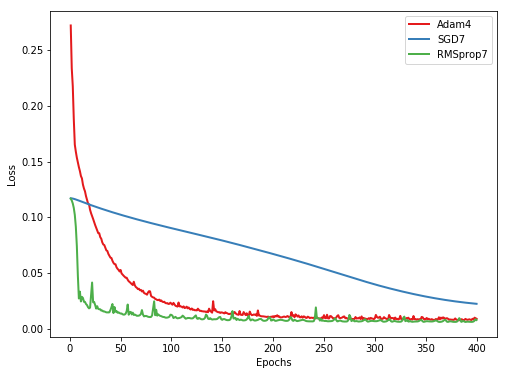

In [68]:
bigger_networks_path = [
    'Adam4',#'Adam7','Adam9',
    'SGD7',
    #'RMSprop4',
    'RMSprop7'
]
smaller_networks_path = [
    'SmallAdam2',#'SmallAdam4','SmallAdam9',
    'SmallSGD7',
    'SmallRMSprop4'#,'SmallRMSprop9'
]
losses = {}
accuracies = {}

colors = plt.get_cmap('Set1')
iterator = 0
fig = plt.figure(figsize = (8,6))

for net in bigger_networks_path:
    with open(net+'/results.json', 'r') as f:
        tmp_dict = json.load(f)
        losses[net] = tmp_dict['history']['loss']
        #accuracies[net] = tmp_dict['history']['acc']
    plt.plot(np.arange(1,401), losses[net], color=colors(iterator), linewidth=2, label=net)
    #plt.plot(np.arange(1,401), accuracies[net], color=colors(iterator), linewidth=1, label=net[5:])
    iterator +=1
    
plt.legend(loc=1, ncol=1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.savefig('loss_bigger.png', dpi=fig.dpi)


# Testing autoencoder
Predykcja i ewaluacja wytrenowanych modeli

In [78]:
x_test300 = prepareData('rgbtest300', 'gray')
x_test300 = x_test300[:, :, :, np.newaxis].astype('float32')
y_test300 = prepareData('rgbtest300', '')

x_test200 = prepareData('rgbtest200', 'gray')
x_test200 = x_test200[:, :, :, np.newaxis].astype('float32')
y_test200 = prepareData('rgbtest200', '')

x_test250 = prepareData('rgbtest250', 'gray')
x_test250 = x_test250[:, :, :, np.newaxis].astype('float32')
y_test250 = prepareData('rgbtest250', '')

In [79]:
results200 = new_model.evaluate(x_test200, y_test200)
results250 = new_model.evaluate(x_test250, y_test250)
results300 = new_model.evaluate(x_test300, y_test300)    

loss = results200[0]*len(x_test200)+ results250[0]*len(x_test250)+ results300[0]*len(x_test300)
accuracy = results200[1]*len(x_test200)+ results250[1]*len(x_test250)+ results300[1]*len(x_test300)

loss = loss / (len(x_test200)+len(x_test250)+len(x_test300))
accuracy = accuracy / (len(x_test200)+len(x_test250)+len(x_test300))
print(loss, accuracy)

4/1 [========================================================================================================================] - 2s 452ms/sample - loss: 0.0059 - acc: 0.5816
0.008908368467998046 0.6948015002103952


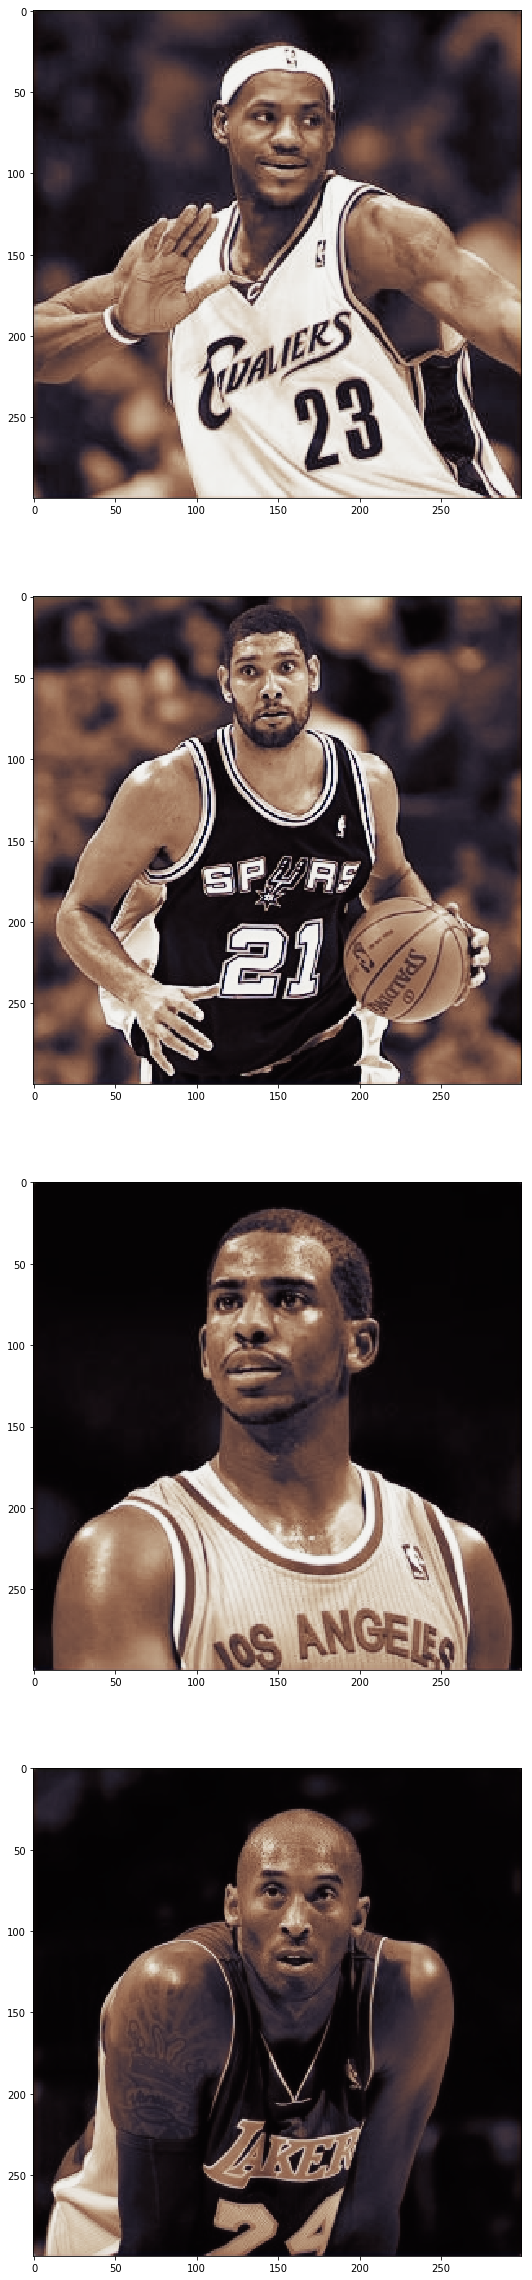

In [81]:
values = new_model.predict( x_test300 )
f = plt.figure(figsize = (300,300))
for i in range(len(values)):
    f.add_subplot(n,1 , i + 1)
    #plt.imsave( path+'/test300_{}.png'.format( i + 1 ) , image_final)
    image_final = ( values[i] * 255).astype( np.uint8 )
    plt.imshow(image_final)
    
plt.show(block=True)